In [1]:
# ### Cell 1: Imports ###
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from pathlib import Path
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# ### Cell 2: Load and Preprocess Data ###
# # UPDATED FOR 3D: Added 'z' to input and 'Uz' to output
# df = pd.read_csv('/kaggle/input/2d-trapezium/concatenated_data_all_steps.csv')
# df_subset = df.groupby('time', group_keys=False).head(50)
# print(f"Original shape: {df.shape}")
# print(f"Subset shape: {df_subset.shape}")

# # Optional — check how many unique time steps and how many samples per step
# print(f"Unique time steps: {df_subset['time'].nunique()}")
# print(df_subset['time'].value_counts().head())

# X = df_subset[['time', 'x', 'y']].values
# Y = df_subset[['Ux', 'Uy', 'p']].values

# X_all = df[['time', 'x', 'y']].values
# Y_all = df[['Ux', 'Uy', 'p']].values

# y_scaler = StandardScaler()
# Y_scaled = y_scaler.fit_transform(Y)
# Y_scaled_all = y_scaler.transform(Y_all)

# x_train_tensor = torch.tensor(X, dtype=torch.float32)
# y_train_tensor = torch.tensor(Y_scaled, dtype=torch.float32)
# y_all_tensor = torch.tensor(Y_scaled_all,dtype=torch.float32)

# print(f"Input shape: {x_train_tensor.shape}")
# print(f"Output shape: {y_train_tensor.shape}")

df = pd.read_csv('/kaggle/input/arko-bera/5_Blocks.csv')

# reduce points per timestep
df_subset = df.groupby('time', group_keys=False).head(1500)

# Inputs
coords_np = df_subset[['time','x','y']].values.astype(np.float32)

# Outputs: u, v, p
Y_np = df_subset[['Ux','Uy','p']].values.astype(np.float32)

# RANS stresses -- not present, so zeros
R_np = np.zeros((len(Y_np), 3), dtype=np.float32)

Y_full = np.concatenate([Y_np, R_np], axis=1)  # [u,v,p,uu,uv,vv]

# Scale outputs
y_scaler = StandardScaler()
Y_scaled = y_scaler.fit_transform(Y_full)

coords_tensor = torch.tensor(coords_np, dtype=torch.float32)
y_tensor = torch.tensor(Y_scaled, dtype=torch.float32)

In [3]:
# ### Cell 3: Visualization Functions ###
# def plot_mesh(x, y):
#     # This remains a 2D plot, showing a projection or slice
#     fig = plt.figure(figsize=(12, 4))
#     ax = fig.add_subplot(111)
#     ax.scatter(x, y, c='k', s=0.1)
#     ax.set_title('Mesh (2D Slice/Projection)')
#     ax.set_aspect(1)
#     plt.show()

# # UPDATED FOR 3D: Added 'w' (for Uz)
# def plot_flow_variables(x, y, u, v, w, p):
#     variables = [u, v, w, p]
#     titles = ['Ux', 'Uy', 'Uz', 'p'] # Added U_z
#     n_variables = len(variables)
#     fig, ax = plt.subplots(n_variables, 1, figsize=(12, 14)) # Increased figure size
#     fig.tight_layout(pad=5.0)
    
#     # This still uses tricontourf, so it plots a 2D slice
#     for i, variable in enumerate(variables):
#         if x.shape[0] > 0 and y.shape[0] > 0 and variable.shape[0] > 0:
#             try:
#                 contour = ax[i].tricontourf(x, y, variable, levels=50, cmap='jet')
#                 ax[i].set_aspect(1)
#                 fig.colorbar(contour, ax=ax[i])
#                 ax[i].set_title(titles[i])
#             except Exception as e:
#                 ax[i].set_title(f"{titles[i]} - Plotting Error: {e}")
#         else:
#             ax[i].set_title(f"{titles[i]} - No data to plot")
#     plt.show()

# collocation samples
def sample_collocation(coords, y, n=4000):
    idx = np.random.choice(coords.shape[0], n, replace=False)
    return coords[idx], y[idx]

coords_c, y_c = sample_collocation(coords_np, Y_scaled, n=3500)

coords_c = torch.tensor(coords_c, dtype=torch.float32)
y_c = torch.tensor(y_c, dtype=torch.float32)

# split train/val
idx = np.random.permutation(len(coords_c))
train_len = int(0.8 * len(idx))

train_idx = idx[:train_len]
val_idx = idx[train_len:]

coords_train = coords_c[train_idx]
y_train = y_c[train_idx]
coords_val = coords_c[val_idx]
y_val = y_c[val_idx]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

coords_train = coords_train.to(device)
y_train = y_train.to(device)
coords_val = coords_val.to(device)
y_val = y_val.to(device)

In [4]:
### Cell 4: Plot Initial Data (at t=0.1 and a z-slice) ###
# UPDATED FOR 3D: Plotting a 2D slice from the 3D data
# df_t1 = df[df['time'] == 0.1]
# # Plot a slice at the median z-value for this timestep
# z_slice_val = df_t1['z'].median()
# df_slice = df_t1[df_t1['z'] == z_slice_val]

# print(f"Plotting 2D slice at t=0.1, z={z_slice_val}")
# plot_mesh(df_slice['x'].values, df_slice['y'].values)
# plot_flow_variables(df_slice['x'].values, df_slice['y'].values, 
#                     df_slice['Ux'].values, df_slice['Uy'].values, 
#                     df_slice['Uz'].values, df_slice['p'].values)

### 2D-Unsteady PINN Model ###
class PINN2D(nn.Module):
    def __init__(self, input_dim=3, output_dim=6, hidden_dim=256, num_layers=8):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, output_dim))

        self.layers = nn.ModuleList(layers)
        self.activation = torch.tanh
        self._init_weights()

    def _init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)


In [5]:
# ### Cell 5: Define PDE Loss (Unsteady Laminar 2D Navier-Stokes) ###
# nu = 1e-05

# def pde_loss(t, x, y, pred):
#     # u(x,y,t), v(x,y,t), p(x,y,t)
#     u, v, p = pred[:, 0:1], pred[:, 1:2], pred[:, 2:3]

#     # First derivatives
#     u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
#     u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
#     u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
#     v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
#     v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
#     v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]

#     p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
#     p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

#     # Second derivatives (Laplacian)
#     u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
#     u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    
#     v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
#     v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

#     # Continuity equation (2D)
#     cont = u_x + v_y

#     # Momentum equations
#     # x-momentum
#     f = u_t + (u * u_x + v * u_y) + p_x - nu * (u_xx + u_yy)

#     # y-momentum
#     g = v_t + (u * v_x + v * v_y) + p_y - nu * (v_xx + v_yy)

#     # Losses
#     f_loss = (f ** 2).mean()
#     g_loss = (g ** 2).mean()
#     cont_loss = (cont ** 2).mean()
    
#     return f_loss + g_loss + cont_loss

nu = 1e-5   # kinematic viscosity

def pde_loss_rans(coords, pred):
    # split coords
    t = coords[:,0:1]
    x = coords[:,1:2]
    y = coords[:,2:3]

    # outputs
    u = pred[:,0:1]
    v = pred[:,1:2]
    p = pred[:,2:3]
    uu = pred[:,3:4]
    uv = pred[:,4:5]
    vv = pred[:,5:6]

    # gradients
    u_grads = torch.autograd.grad(u, coords, torch.ones_like(u), create_graph=True)[0]
    v_grads = torch.autograd.grad(v, coords, torch.ones_like(v), create_graph=True)[0]
    p_grads = torch.autograd.grad(p, coords, torch.ones_like(p), create_graph=True)[0]

    u_t = u_grads[:,0:1]; u_x = u_grads[:,1:2]; u_y = u_grads[:,2:3]
    v_t = v_grads[:,0:1]; v_x = v_grads[:,1:2]; v_y = v_grads[:,2:3]
    p_x = p_grads[:,1:2]; p_y = p_grads[:,2:3]

    u_xx = torch.autograd.grad(u_x, coords, torch.ones_like(u_x), create_graph=True)[0][:,1:2]
    u_yy = torch.autograd.grad(u_y, coords, torch.ones_like(u_y), create_graph=True)[0][:,2:3]
    v_xx = torch.autograd.grad(v_x, coords, torch.ones_like(v_x), create_graph=True)[0][:,1:2]
    v_yy = torch.autograd.grad(v_y, coords, torch.ones_like(v_y), create_graph=True)[0][:,2:3]

    uu_x = torch.autograd.grad(uu, coords, torch.ones_like(uu), create_graph=True)[0][:,1:2]
    uv_x = torch.autograd.grad(uv, coords, torch.ones_like(uv), create_graph=True)[0][:,1:2]
    uv_y = torch.autograd.grad(uv, coords, torch.ones_like(uv), create_graph=True)[0][:,2:3]
    vv_y = torch.autograd.grad(vv, coords, torch.ones_like(vv), create_graph=True)[0][:,2:3]

    # PDE residuals
    f = u_t + u*u_x + v*u_y + p_x - nu*(u_xx + u_yy) + uu_x + uv_y
    g = v_t + u*v_x + v*v_y + p_y - nu*(v_xx + v_yy) + uv_x + vv_y

    cont = u_x + v_y

    return (f**2).mean() + (g**2).mean() + (cont**2).mean()

In [6]:
# ### Cell 6: Define the Model (Standard PINN) ###
# class PINN3D(nn.Module):
#     def __init__(self, input_dim=3, output_dim=3, hidden_dim=256, num_layers=8):
#         super(PINN3D, self).__init__()
#         layers = []
#         layers.append(nn.Linear(input_dim, hidden_dim))
#         for _ in range(num_layers - 2):
#             layers.append(nn.Linear(hidden_dim, hidden_dim))
#         layers.append(nn.Linear(hidden_dim, output_dim))

#         self.layers = nn.ModuleList(layers)
#         self.activation = torch.tanh  # recommended for PINNs
        
#         # Xavier init (important for PINN stability)
#         self._initialize_weights()

#     def _initialize_weights(self):
#         for layer in self.layers:
#             if isinstance(layer, nn.Linear):
#                 nn.init.xavier_uniform_(layer.weight)
#                 if layer.bias is not None:
#                     nn.init.zeros_(layer.bias)

#     def forward(self, x):
#         # Simple forward pass without Fourier embedding
#         for layer in self.layers[:-1]:
#             x = self.activation(layer(x))
#         return self.layers[-1](x)

def train_pinn(model, optimizer, iters, coords_train, y_train, coords_val, y_val):
    logs = {"iter": [], "data": [], "pde": [], "val": [], "total": []}

    lam = 1e-2
    lam_end = 1.0
    lam_growth = (lam_end / lam) ** (1/iters)

    best = 9999
    patience = 500
    counter = 0

    for it in range(1, iters+1):
        optimizer.zero_grad()

        coords = coords_train.clone().detach().requires_grad_(True)
        pred = model(coords)

        data_loss = F.mse_loss(pred, y_train)
        pde_loss = pde_loss_rans(coords, pred)

        total_loss = data_loss + lam * pde_loss
        total_loss.backward()
        optimizer.step()

        # validation
        model.eval()
        with torch.no_grad():
            val_pred = model(coords_val)
            val_loss = F.mse_loss(val_pred, y_val)
        model.train()

        logs["iter"].append(it)
        logs["data"].append(data_loss.item())
        logs["pde"].append(pde_loss.item())
        logs["total"].append(total_loss.item())
        logs["val"].append(val_loss.item())

        if it % 100 == 0:
            print(f"Iter {it} | λ={lam:.4f} | Data={data_loss:.3f} PDE={pde_loss:.3f} Val={val_loss:.3f}")

        # checkpoint
        if val_loss < best:
            best = val_loss
            counter = 0
            torch.save(model.state_dict(), "best_rans2d.pth")
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping.")
            break

        lam *= lam_growth
        lam = min(lam, lam_end)

    model.load_state_dict(torch.load("best_rans2d.pth"))
    print("Best model Loaded.")
    return logs

In [7]:
### Cell 6: Define the Model (PirateNet) ###
# This class definition is generic and does not need changes
# The input_dim and output_dim are set during instantiation
# class PirateNetBlock(nn.Module):
#     def __init__(self, hidden_dim):
#         super(PirateNetBlock, self).__init__()
#         self.dense1 = nn.Linear(hidden_dim, hidden_dim)
#         self.dense2 = nn.Linear(hidden_dim, hidden_dim)
#         self.dense3 = nn.Linear(hidden_dim, hidden_dim)
#         self.alpha = nn.Parameter(torch.zeros(1))

#     def forward(self, x, u, v):
#         f = F.tanh(self.dense1(x))
#         z1 = f * u + (1 - f) * v
#         g = F.tanh(self.dense2(z1))
#         z2 = g * u + (1 - g) * v
#         h = F.tanh(self.dense3(z2))
#         return self.alpha * h + (1 - self.alpha) * x

# class PirateNet(nn.Module):
#     def __init__(
#         self,
#         input_dim,
#         output_dim,
#         num_blocks,
#         hidden_dim=256,
#         s=1.0,
#         activation=F.tanh,
#     ):
#         super(PirateNet, self).__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.num_blocks = num_blocks
#         self.hidden_dim = hidden_dim
#         self.s = s
#         self.activation = activation
#         self.B = nn.Parameter(torch.randn(input_dim, hidden_dim // 2) * s)
#         self.embedding = lambda x: torch.cat(
#             [torch.cos(torch.matmul(x, self.B)), torch.sin(torch.matmul(x, self.B))],
#             dim=-1,
#         )
#         self.blocks = nn.ModuleList(
#             [PirateNetBlock(hidden_dim) for _ in range(num_blocks)]
#         )
#         self.U = nn.Linear(hidden_dim, hidden_dim)
#         self.V = nn.Linear(hidden_dim, hidden_dim)
#         self.final_layer = nn.Linear(hidden_dim, output_dim, bias=False)
#         print(f"Final layer weights shape: {self.final_layer.weight.data.shape}")
#         self.initialize_weights()

#     def initialize_weights(self):
#         for module in self.modules():
#             if isinstance(module, nn.Linear):
#                 torch.nn.init.xavier_uniform_(module.weight)
#                 if module.bias is not None:
#                     module.bias.data.zero_()

#     def forward(self, x):
#         x = self.embedding(x)
#         u = self.activation(self.U(x))
#         v = self.activation(self.V(x))
#         for block in self.blocks:
#             x = block(x, u, v)
#         return self.final_layer(x)

model = PINN2D(input_dim=3, output_dim=6, hidden_dim=256, num_layers=8).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

logs = train_pinn(
    model=model,
    optimizer=optimizer,
    iters=2500,
    coords_train=coords_train,
    y_train=y_train,
    coords_val=coords_val,
    y_val=y_val
)

Iter 100 | λ=0.0120 | Data=0.438 PDE=0.481 Val=0.402
Iter 200 | λ=0.0144 | Data=0.352 PDE=0.921 Val=0.355
Iter 300 | λ=0.0173 | Data=0.342 PDE=0.138 Val=0.347
Iter 400 | λ=0.0209 | Data=0.360 PDE=0.046 Val=0.365
Iter 500 | λ=0.0251 | Data=0.338 PDE=0.030 Val=0.344
Iter 600 | λ=0.0301 | Data=0.526 PDE=0.058 Val=0.432
Iter 700 | λ=0.0362 | Data=0.427 PDE=0.378 Val=0.419
Iter 800 | λ=0.0436 | Data=0.391 PDE=0.177 Val=0.396
Iter 900 | λ=0.0524 | Data=0.372 PDE=0.050 Val=0.377
Iter 1000 | λ=0.0630 | Data=0.561 PDE=0.001 Val=0.428
Early stopping.
Best model Loaded.


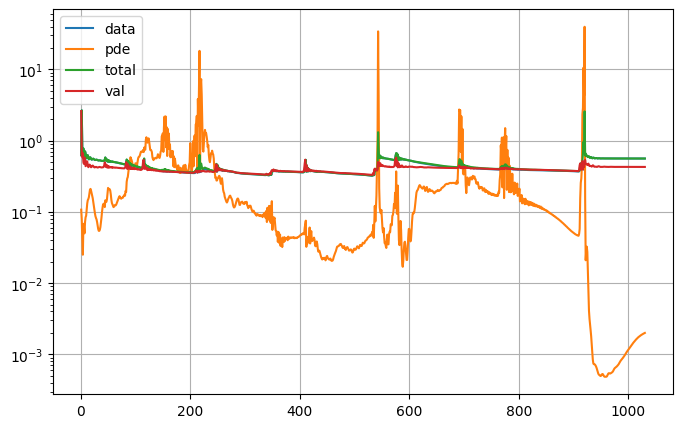

In [8]:
# %%time

# ### Cell 7: Training Loop (with Early Stopping) ###
# def train_model(model, optimizer, iterations, x_train, y_train, val_x, val_y):
#     logs={"iteration": [], "loss_from_pde": [], "loss_from_data": [], "total_loss": [], "val_loss": []}
#     best_val_loss=float('inf')
#     patience=50 
#     patience_counter=0
    
#     def closure():
#         # UPDATED FOR 3D: Unpack t, x, y, z
#         t, x, y, z = x_train[:, 0:1], x_train[:, 1:2], x_train[:, 2:3], x_train[:, 3:4]
#         t.requires_grad_(True)
#         x.requires_grad_(True)
#         y.requires_grad_(True)
#         z.requires_grad_(True) # Set requires_grad for z
        
#         # UPDATED FOR 3D: Catenate t, x, y, z
#         input_tensor = torch.cat([t, x, y, z], dim=1)
#         pred = model(input_tensor)
        
#         optimizer.zero_grad()
        
#         loss_from_data = F.mse_loss(pred, y_train)
        
#         # UPDATED FOR 3D: Pass z to pde_loss
#         loss_from_pde = pde_loss(t, x, y, z, pred)
        
#         loss = 0.01*loss_from_pde + loss_from_data
#         loss.backward()
        
#         closure.iteration += 1
#         model.eval()
#         with torch.no_grad():
#             val_pred = model(val_x)
#             val_loss = F.mse_loss(val_pred, val_y)
#         model.train()
        
#         logs["iteration"].append(closure.iteration)
#         logs["loss_from_pde"].append(loss_from_pde.item())
#         logs["loss_from_data"].append(loss_from_data.item())
#         logs["total_loss"].append(loss.item())
#         logs["val_loss"].append(val_loss.item())
        
#         if closure.iteration % 100 == 0:
#             print(
#                 f"Iteration {closure.iteration}. PDE loss: {loss_from_pde.item():.4f}, Data loss: {loss_from_data.item():.4f}, Val loss: {val_loss.item():.4f}"
#             )
            
#         closure.best_val_loss = best_val_loss
#         closure.patience_counter = patience_counter
        
#         if val_loss.item() < closure.best_val_loss:
#             closure.best_val_loss = val_loss.item()
#             closure.patience_counter = 0
#             torch.save(model.state_dict(), 'best_model_adam.pth')
#         else:
#             closure.patience_counter += 1
            
#         return loss
    
#     closure.iteration = 0
#     closure.best_val_loss = best_val_loss
#     closure.patience_counter = patience_counter
    
#     try:
#         if isinstance(optimizer, torch.optim.LBFGS):
#             # optimizer.step(closure)
#             optimizer.zero_grad()
#             loss = closure()
#             optimizer.step()
#         else:
#             for iteration in range(iterations):
#                 loss = optimizer.step(closure)
#                 if closure.patience_counter >= patience:
#                     print(f"Early stopping at iteration {closure.iteration}")
#                     break
            
#     except KeyboardInterrupt: 
#         print('Training stopped manually')
    
#     model.load_state_dict(torch.load('best_model_adam.pth'))
#     return logs
    
# # UPDATED FOR 3D: Input dim is 4 (t, x, y, z)
# input_dim = 4
# # UPDATED FOR 3D: Output dim is 4 (u, v, w, p)
# output_dim = 4
# n_layers = 8
# layer_dim = 256

# ### Cell 8: Setup Training ###
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# torch.manual_seed(42)
# indices = torch.randperm(x_train_tensor.size(0))
# train_size = int(0.8 * x_train_tensor.size(0))

# x_train = x_train_tensor[indices[:train_size]].to(device)
# y_train = y_train_tensor[indices[:train_size]].to(device)
# x_val = x_train_tensor[indices[train_size:]].to(device)
# y_val = y_train_tensor[indices[train_size:]].to(device)

# model = PINN3D(
#     input_dim=input_dim,
#     output_dim=output_dim,
#     hidden_dim=layer_dim,
#     num_layers=n_layers
# ).to(device)


# ### Cell 9: Train with Adam ###
# lr = 0.001
# iterations = 3000 
# optimizer_adam = optim.Adam(model.parameters(), lr=lr)
# logs_adam = train_model(model, optimizer_adam, iterations, x_train, y_train, x_val, y_val)

plt.figure(figsize=(8,5))
plt.plot(logs["iter"], logs["data"], label='data')
plt.plot(logs["iter"], logs["pde"], label='pde')
plt.plot(logs["iter"], logs["total"], label='total')
plt.plot(logs["iter"], logs["val"], label='val')
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# def train_pinn_with_curriculum(model, optimizer, iterations, x_train, y_train, val_x, val_y, pde_loss_fn):
#     """
#     Trains a PINN with curriculum weighting on the PDE loss.
#     λ starts small and grows during training to balance data fitting and physics consistency.
#     """

#     logs = {
#         "iteration": [], 
#         "data_loss": [], 
#         "pde_loss": [], 
#         "total_loss": [], 
#         "val_loss": []
#     }

#     best_val_loss = float('inf')
#     patience = 500
#     patience_counter = 0

#     # Curriculum parameters
#     λ_start = 1e-4
#     λ_end = 1.0
#     λ_growth = (λ_end / λ_start) ** (1 / iterations)  # geometric growth rate
#     λ = λ_start

#     for iteration in range(1, iterations + 1):
#         model.train()
#         optimizer.zero_grad()

#         # Split inputs (t, x, y, z)
#         t, x, y = (
#             x_train[:, 0:1],
#             x_train[:, 1:2],
#             x_train[:, 2:3],
#         )
#         t.requires_grad_(True)
#         x.requires_grad_(True)
#         y.requires_grad_(True)

#         # Forward pass
#         pred = model(torch.cat([t, x, y], dim=1))

#         # Compute losses
#         data_loss = F.mse_loss(pred, y_train)
#         pde_loss = pde_loss_fn(t, x, y, pred)
#         total_loss = data_loss + λ * pde_loss

#         total_loss.backward()
#         optimizer.step()

#         # Validation
#         model.eval()
#         with torch.no_grad():
#             val_pred = model(val_x)
#             val_loss = F.mse_loss(val_pred, val_y)

#         # Log values
#         logs["iteration"].append(iteration)
#         logs["data_loss"].append(data_loss.item())
#         logs["pde_loss"].append(pde_loss.item())
#         logs["total_loss"].append(total_loss.item())
#         logs["val_loss"].append(val_loss.item())

#         if iteration % 100 == 0 or iteration == 1:
#             print(
#                 f"Iter {iteration:4d} | λ={λ:.6f} | "
#                 f"Data Loss={data_loss.item():.4f}, PDE Loss={pde_loss.item():.4f}, "
#                 f"Val Loss={val_loss.item():.4f}"
#             )

#         # Early stopping logic
#         if val_loss.item() < best_val_loss:
#             best_val_loss = val_loss.item()
#             patience_counter = 0
#             torch.save(model.state_dict(), "best_pinn_model_curriculum.pth")
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print(f"Early stopping at iteration {iteration}")
#             break

#         # Update λ (grow gradually)
#         λ *= λ_growth
#         λ = min(λ, λ_end)  # clamp to max

#     # Load best model
#     model.load_state_dict(torch.load("best_pinn_model_curriculum.pth"))
#     print("✅ Best model loaded from checkpoint.")
#     return logs

X_all = df[['time','x','y']].values.astype(np.float32)
Y_all = df[['Ux','Uy','p']].values.astype(np.float32)
R_all = np.zeros((len(Y_all),3))

Y_all_full = np.concatenate([Y_all, R_all], axis=1)
Y_scaled_all = y_scaler.transform(Y_all_full)
y_all_tensor = torch.tensor(Y_scaled_all, dtype=torch.float32)

model.eval()
with torch.no_grad():
    pred_scaled = model(torch.tensor(X_all, dtype=torch.float32).to(device))

pred_scaled_np = pred_scaled.cpu().numpy()
pred_orig = y_scaler.inverse_transform(pred_scaled_np)
true_orig = y_scaler.inverse_transform(y_all_tensor.numpy())

# Extract
u_pred, v_pred, p_pred = pred_orig[:,0], pred_orig[:,1], pred_orig[:,2]
u_true, v_true, p_true = true_orig[:,0], true_orig[:,1], true_orig[:,2]

In [10]:
# import matplotlib.pyplot as plt

# def plot_training_logs(logs, title="ANN Training Progress"):
#     """
#     Plots training and validation loss curves from the logs dictionary.
#     Args:
#         logs: dict with keys ['iteration', 'train_loss', 'val_loss']
#         title: plot title
#     """
#     plt.figure(figsize=(8, 5))
#     plt.plot(logs["iteration"], logs["data_loss"], label="MSE Loss", linewidth=2)
#     plt.plot(logs["iteration"], logs["pde_loss"], label="PDE Loss", linewidth=2)
#     plt.plot(logs["iteration"], logs["total_loss"], label="Total Loss", linewidth=2)
#     plt.plot(logs["iteration"], logs["val_loss"], label="Validation Loss", linewidth=2)
#     plt.xlabel("Iteration", fontsize=12)
#     plt.ylabel("MSE Loss", fontsize=12)
#     plt.title(title, fontsize=14)
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.show()
### Cell — Display Metrics for u, v, p ###

# Metric functions
def MAE(pred, true): return np.mean(np.abs(pred - true))
def MSE(pred, true): return np.mean((pred - true)**2)
def L2(pred, true):  return np.linalg.norm(pred - true) / np.linalg.norm(true)

# Compute metrics
metrics = {
    "u": (MAE(u_pred, u_true), MSE(u_pred, u_true), L2(u_pred, u_true)),
    "v": (MAE(v_pred, v_true), MSE(v_pred, v_true), L2(v_pred, v_true)),
    "p": (MAE(p_pred, p_true), MSE(p_pred, p_true), L2(p_pred, p_true)),
}

# Print nicely
print("\n===== MODEL PERFORMANCE (u, v, p) =====\n")
print(f"{'Component':<10} {'MAE':>12} {'MSE':>12} {'L2':>12}")
print("-"*50)
for comp, (mae, mse, l2) in metrics.items():
    print(f"{comp:<10} {mae:12.6f} {mse:12.6f} {l2:12.6f}")

# Velocity magnitude
vel_pred = np.sqrt(u_pred**2 + v_pred**2)
vel_true = np.sqrt(u_true**2 + v_true**2)

print("\nVelocity Magnitude Error:")
print(f"MAE = {MAE(vel_pred, vel_true):.6f}")
print(f"MSE = {MSE(vel_pred, vel_true):.6f}")
print(f"L2  = {L2(vel_pred, vel_true):.6f}")


===== MODEL PERFORMANCE (u, v, p) =====

Component           MAE          MSE           L2
--------------------------------------------------
u              0.026491     0.003683     0.060893
v              0.000513     0.000001     0.999292
p              0.021149     0.000731     0.690651

Velocity Magnitude Error:
MAE = 0.026491
MSE = 0.003683
L2  = 0.060893


In [11]:

# # UPDATED FOR 3D: Input dim is 4 (t, x, y, z)
# input_dim = 3
# # UPDATED FOR 3D: Output dim is 4 (u, v, w, p)
# output_dim = 3
# n_layers = 8
# layer_dim = 256

# ### Cell 8: Setup Training ###
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# torch.manual_seed(42)
# indices = torch.randperm(x_train_tensor.size(0))
# train_size = int(0.8 * x_train_tensor.size(0))

# x_train = x_train_tensor[indices[:train_size]].to(device)
# y_train = y_train_tensor[indices[:train_size]].to(device)
# x_val = x_train_tensor[indices[train_size:]].to(device)
# y_val = y_train_tensor[indices[train_size:]].to(device)

# model = PINN3D(
#     input_dim=input_dim,
#     output_dim=output_dim,
#     hidden_dim=layer_dim,
#     num_layers=n_layers
# ).to(device)

# lr = 0.001
# iterations = 3000 
# optimizer_adam = optim.Adam(model.parameters(), lr=lr)
# logs_adam = train_pinn_with_curriculum(model, optimizer_adam, iterations, x_train, y_train, x_val, y_val,pde_loss_fn=pde_loss)

In [12]:
# plot_training_logs(logs_adam, title="2D PINN Training and Validation Loss")

In [13]:
# ### Cell 15: Calculate L2 Error on Training Data ###
# model.eval()
# with torch.no_grad():
#     # Predict on the full dataset
#     x_all_tensor = torch.tensor(X_all, dtype=torch.float32).to(device)
#     y_pred_scaled = model(x_all_tensor)

# # Convert predictions and ground truth back to original scale
# y_pred_orig = y_scaler.inverse_transform(y_pred_scaled.cpu().numpy())
# y_true_orig = y_scaler.inverse_transform(y_all_tensor.cpu().numpy())



# # ---- Compute metrics per component ----
# mae = np.mean(np.abs(y_pred_orig - y_true_orig), axis=0)
# mse = np.mean((y_pred_orig - y_true_orig) ** 2, axis=0)
# l2 = np.linalg.norm(y_pred_orig - y_true_orig, axis=0) / np.linalg.norm(y_true_orig, axis=0)





# # ---- Print results ----
# components = ['U_x', 'U_y', 'p']
# print("\n=== Full-Dataset Evaluation ===")
# for i, comp in enumerate(components):
#     print(f"{comp}: MAE = {mae[i]:.4f}, MSE = {mse[i]:.4f}, L2 = {l2[i]:.4f}")





# # ---- Optional: Velocity magnitude evaluation ----
# vel_pred = np.sqrt(np.sum(y_pred_orig[:, :3] ** 2, axis=1))
# vel_true = np.sqrt(np.sum(y_true_orig[:, :3] ** 2, axis=1))

# mae_vel = np.mean(np.abs(vel_pred - vel_true))
# mse_vel = np.mean((vel_pred - vel_true) ** 2)
# l2_vel = np.linalg.norm(vel_pred - vel_true) / np.linalg.norm(vel_true)

# print(f"\nVelocity Magnitude: MAE = {mae_vel:.4f}, MSE = {mse_vel:.4f}, L2 = {l2_vel:.4f}")